In [136]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import datetime

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-28,23.225000,23.415001,23.035000,23.397499,21.604420,161779600
2016-06-29,23.492500,23.637501,23.407499,23.600000,21.791401,146124000
2016-06-30,23.610001,23.942499,23.575001,23.900000,22.068409,143345600
2016-07-01,23.872499,24.117500,23.832500,23.972500,22.135353,104106000
2016-07-05,23.847500,23.850000,23.615000,23.747499,21.927599,110820800
...,...,...,...,...,...,...
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.960007,49515700
2023-06-22,183.740005,187.050003,183.669998,187.000000,187.000000,51245300
2023-06-23,185.550003,187.559998,185.009995,186.679993,186.679993,53079300


In [137]:
# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences for LSTM and GRU models
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Create sequences for LSTM and GRU models
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

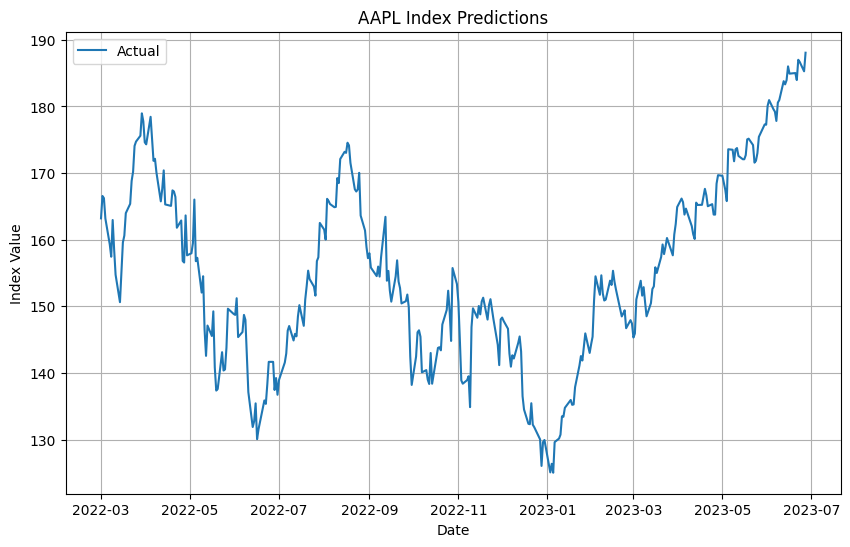

In [139]:
# Build the ARIMA model
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Generate predictions for the ARIMA model
# arima_predictions = arima_model_fit.forecast(steps=len(test_data))[0]
# arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(data)-1)
arima_predictions = scaler.inverse_transform(arima_predictions.reshape(-1, 1))

# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
# arima_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], arima_predictions))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
# plt.plot(dataset.index[train_size+sequence_length:], arima_predictions, label=f'ARIMA (RMSE: {arima_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

# Calculate RMSE for each model
lstm_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], lstm_predictions))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
plt.plot(dataset.index[train_size+sequence_length:], lstm_predictions, label=f'LSTM (RMSE: {lstm_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()
lstm_rmse

In [ ]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(sequence_length, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Generate predictions for the GRU model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions.reshape(-1, 1))

# Calculate RMSE for each model
gru_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], gru_predictions))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
plt.plot(dataset.index[train_size+sequence_length:], gru_predictions, label=f'GRU (RMSE: {gru_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()
gru_rmse

[*********************100%***********************]  1 of 1 completed
                Close
Date                 
2018-01-02  43.064999
2018-01-03  43.057499
2018-01-04  43.257500
2018-01-05  43.750000
2018-01-08  43.587502


ValueError: x and y must have same first dimension, but have shapes (744,) and (202,)

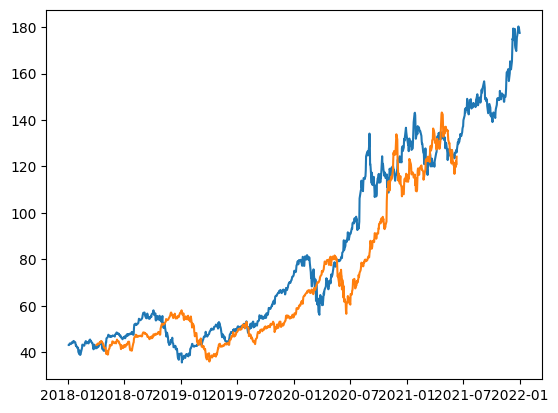

In [146]:
import yfinance as yf

# Define the ticker symbol and the timeframe
ticker_symbol = "AAPL"
start_date = "2018-01-01"
end_date = "2022-01-01"

# Fetch the data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Select the "Close" column for modeling
data = data[["Close"]]

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Split the data into train and test sets
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Prepare the data for LSTM
def prepare_data_for_lstm(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of previous time steps to consider

X_train, y_train = prepare_data_for_lstm(train_data_scaled, time_steps)
X_test, y_test = prepare_data_for_lstm(test_data_scaled, time_steps)

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Display the first few rows of the data
print(data.head())
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data for ARIMA
train_data_arima = train_data["Close"].values
test_data_arima = test_data["Close"].values

# Train the ARIMA model
model = ARIMA(train_data_arima, order=(3, 1, 2))
model_fit = model.fit()

# Make predictions
train_predictions = model_fit.predict(start=1, end=len(train_data_arima)-1, typ='levels')
test_predictions = model_fit.predict(start=len(train_data_arima), end=len(train_data_arima)+len(test_data_arima)-1, typ='levels')
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data for ARIMA
train_data_arima = train_data["Close"].values
test_data_arima = test_data["Close"].values

# Train the ARIMA model
model = ARIMA(train_data_arima, order=(3, 1, 2))
model_fit = model.fit()

# Make predictions
train_predictions = model_fit.predict(start=1, end=len(train_data_arima)-1, typ='levels')
test_predictions = model_fit.predict(start=len(train_data_arima), end=len(train_data_arima)+len(test_data_arima)-1, typ='levels')
import matplotlib.pyplot as plt

# Plot the actual data
plt.plot(data.index, data["Close"], label="Actual")

# # Plot the LSTM predictions
# plt.plot(data.index[time_steps+1:time_steps+1+len(train_predictions)], train_predictions, label="LSTM Train")
# plt.plot(data.index[time_steps+1+len(train_predictions)+1:], test_predictions, label="LSTM Test")

# Plot the GRU predictions
# plt.plot(data.index[time_steps+1:time_steps+1+len(train_predictions)], train_predictions, label="GRU Train")
# plt.plot(data.index[time_steps+1+len(train_predictions)+1:], test_predictions, label="GRU Test")

# Plot the ARIMA predictions
plt.plot(data.index[time_steps+1:time_steps+1+len(train_predictions)], train_predictions, label="ARIMA Train")
plt.plot(data.index[time_steps+1+len(train_predictions)+1:], test_predictions, label="ARIMA Test")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Predictions")
plt.legend()
plt.show()
